In [1]:
%matplotlib inline

from dicom_utils_3 import *
import numpy as np 
import pandas as pd 
import os
import pydicom
import matplotlib.pyplot as plt
#import assd_func as af
from skimage import morphology
import matplotlib.patches as mpatches
import assd_func_Sobel_2 as af_Sobel
import time
import random
from scipy.stats import uniform,norm

In [2]:
organ = "rectum" #Change this your organ

In [3]:
dicom_dir = "C:/Users/lykha/OneDrive/Documents/0_PhD_Spring_2021/Research-main/Research_MDA/Prostate Cases/1"
organ_i = 4
output_dir = "Output"
images_1, slices_1, contours_1, labels_1, dummy_mask_1 = main(dicom_dir, output_dir)

# Rectum

In [4]:
def find_roi_slices(images, labels, i):
    roi_z = []
    for j in range(images.shape[0]):
        if True in np.unique(labels[..., i][j, ...] > 0):
            roi_z.append(j)
    return roi_z

def find_organ_i(organ, contours):
    contour_table = pd.DataFrame()
    number = []
    name = []
    for i in range(len(contours)):
        number.append(contours[i]["number"])
        name.append(contours[i]["name"])
    #contour_table["number"] = number
    contour_table["name"] = name
    #print(contour_table)
    organ_i =  contour_table[contour_table["name"].str.contains(organ)].index.tolist()[0]
    return organ_i

In [5]:
organ_i_1 =  find_organ_i(organ, contours_1)
organ_i_1

4

In [6]:
roi_z_1 = find_roi_slices(images_1, labels_1, organ_i_1)

(-0.5, 511.5, 511.5, -0.5)

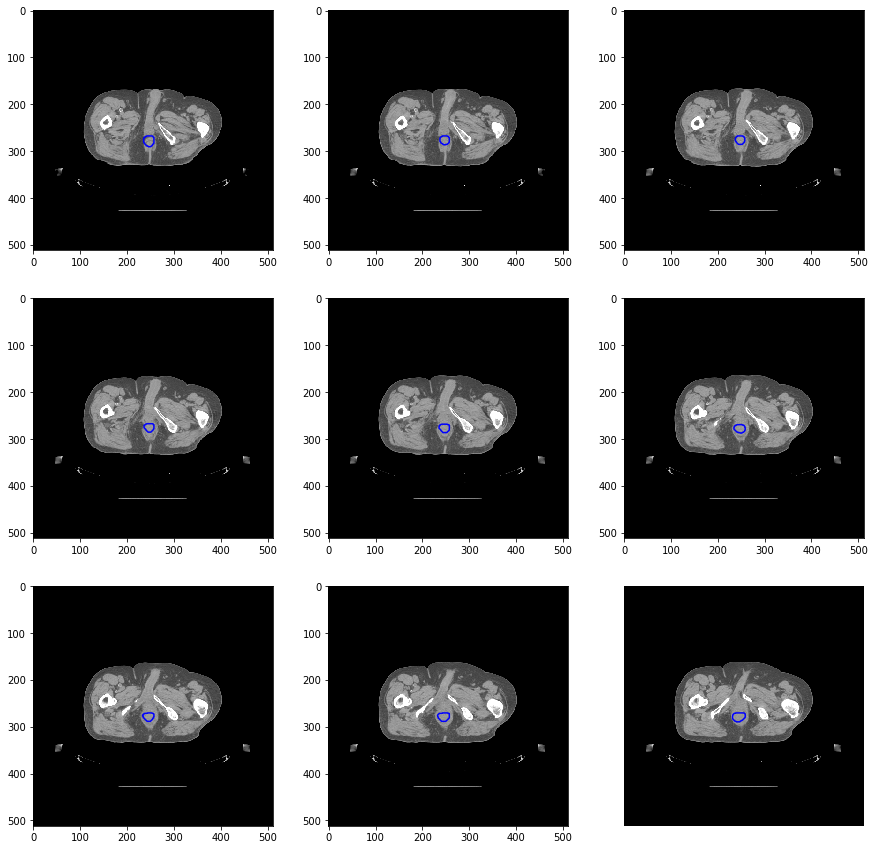

In [7]:
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_1[i + roi_z_1[0], ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(labels_1[..., organ_i_1][i + 63, ...], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.axis('off')

# Option: 3D Gaussian Blur

(200.0, 300.0, 75.0, 100.0)

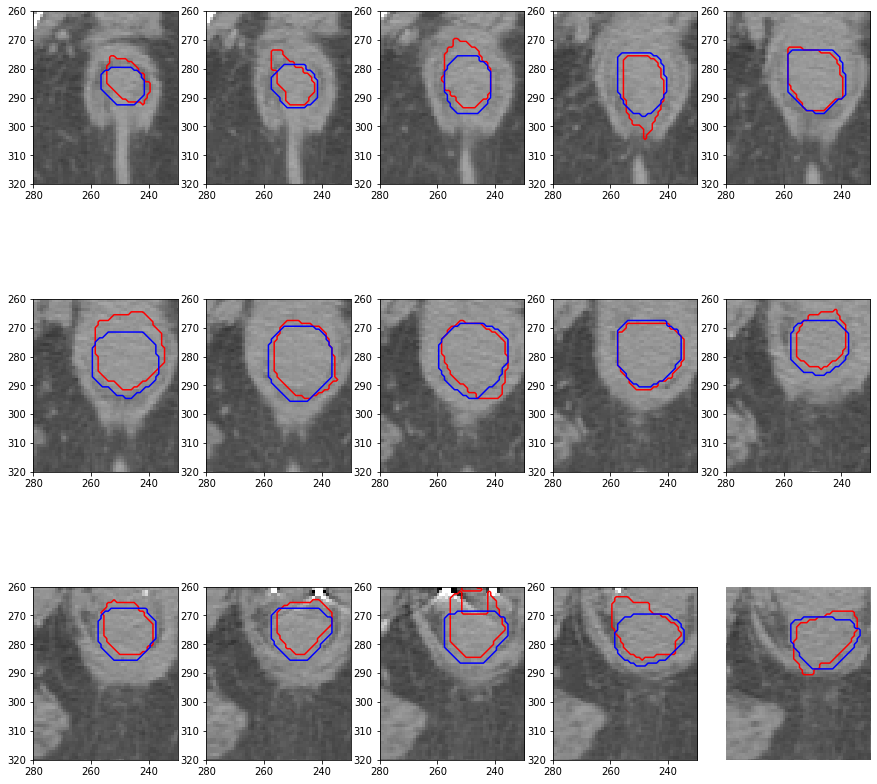

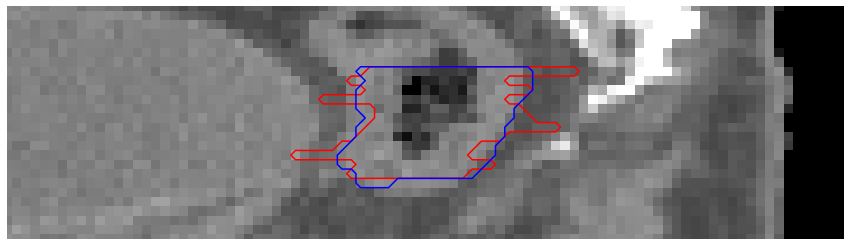

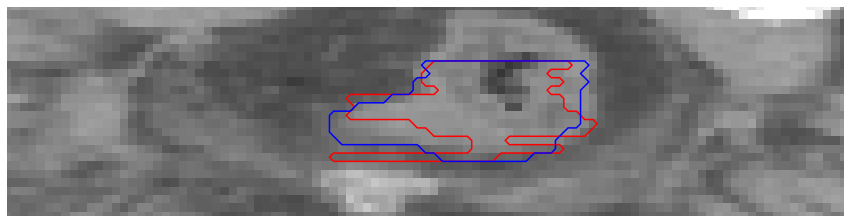

In [8]:
c = 20
k = 15
w = 2
circles = 3
ismax=True
a = 50
SD=[c*1.3, c*1.3, c*3]
voxelsize = np.array([0.1076562, 0.1076562, 2.5])
assd_contour_rectum_1 = labels_1[..., organ_i_1].copy()
seed = 72

for i in roi_z_1:
    dx, dy, mask1, t, L, roi_z_1, i0 = af_Sobel.assd_Sobel(images_1[i, ...], labels_1[..., organ_i_1][i, ...], voxelsize, a, SD, circles, seed, k, w, images_1, labels_1, organ_i_1, ismax=ismax, smooth=True)
    du1 = af_Sobel.plotting_assd(dx, dy, mask1, images_1[i, ...], quiver=False, plot=False) 
    assd_contour_rectum_1[i, ...] = du1  
    
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images_1[roi_z_1[i] , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(assd_contour_rectum_1[roi_z_1[i], ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels_1[roi_z_1[i], ..., organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(280, 230)
    plt.ylim(320, 260)
    #blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    #red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    #plt.legend(handles=[blue_patch, red_patch])
plt.axis('off')

# Plotting along the z axis
plt.figure(figsize=(15, 15))
plt.imshow(images_1[..., 260], cmap="gray", vmin=-250, vmax=250)
plt.contour(assd_contour_rectum_1[..., 260], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
plt.contour(labels_1[..., 260, organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.xlim(250, 340)
plt.ylim(75, 100)
plt.axis('off')

# Plotting along the y axis
plt.figure(figsize=(15, 15))
plt.imshow(images_1[:, 300, :], cmap="gray", vmin=-250, vmax=250)
plt.contour(assd_contour_rectum_1[:, 300, :], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
plt.contour(labels_1[:, 300, :, organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.xlim(200, 300)
plt.ylim(75, 100)
plt.axis('off')

In [30]:
import numpy as np
from scipy import signal

def filter_3D_smoothing(data):
    # first build the smoothing kernel
    sigma = 1.0     # width of kernel
    x = np.arange(-2,3,1)   # coordinate arrays -- make sure they contain 0!
    y = np.arange(-2,3,1)
    z = np.arange(-2,3,1)
    xx, yy, zz = np.meshgrid(x,y,z)
    kernel = np.exp(-(xx**2 + yy**2 + zz**2)/(2*sigma**2))*10
    #print(kernel)
    blur = signal.convolve(data, kernel, mode="same")
    final_du = np.where(blur < 0.5, 0, 4)
    return final_du

In [31]:
smoothed_assd_contour_rectum_1 = filter_3D_smoothing(assd_contour_rectum_1)

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images_1[roi_z_1[i] , ...], cmap="gray", vmin=-250, vmax=250)
    plt.contour(smoothed_assd_contour_rectum_1[roi_z_1[i], ...], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
    plt.contour(labels_1[roi_z_1[i], ..., organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
    plt.xlim(280, 230)
    plt.ylim(320, 260)
    #blue_patch = mpatches.Patch(color='blue', label="Clinician's contour")
    #red_patch = mpatches.Patch(color='red', label='DU contour with random seed 1')
    #plt.legend(handles=[blue_patch, red_patch])
plt.axis('off')

# Plotting along the z axis
plt.figure(figsize=(15, 15))
plt.imshow(images_1[..., 260], cmap="gray", vmin=-250, vmax=250)
plt.contour(smoothed_assd_contour_rectum_1[..., 260], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
plt.contour(labels_1[..., 260, organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.xlim(250, 340)
plt.ylim(75, 100)
plt.axis('off')

# Plotting along the y axis
plt.figure(figsize=(15, 15))
plt.imshow(images_1[:, 300, :], cmap="gray", vmin=-250, vmax=250)
plt.contour(smoothed_assd_contour_rectum_1[:, 300, :], levels = [0.5, 1.5, 2.5, 3.5, 4.5], colors="red")
plt.contour(labels_1[:, 300, :, organ_i_1], levels=[0.5, 1.5, 2.5, 3.5, 4.5], colors="blue")
plt.xlim(200, 300)
plt.ylim(75, 100)
plt.axis('off')

(200.0, 300.0, 75.0, 100.0)